# CSIT5800 Introduction to Big Data


# Group Project: Film Recommendation System


## Description
Blablabla...


## Prerequesite

* pandas
* numpy
* matplotlib
* wordcloud
* nltk
* sklearn
* seaborn
* fuzzywuzzy


## About the data and the context

blabla ...
## Download Area

blablabla....



## Code Part

In [1]:
# %load ./src/exploration.py
import os
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


'''
The features in the raw dataset:

    # movie metadata.csv:
        adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,
        original_language,original_title,overview,popularity,poster_path,
        production_companies,production_countries,release_date,revenue,
        runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count

    # keywords.csv:
        id,keywords

    # credits.csv:
        cast,crew,id
'''

# a function to save the plt figures.
def my_pltsavefig(fig_title, mydir='./figure/', fig_extension='.png'):
    filename = mydir + fig_title.replace(' ', '-') + fig_extension
    if not os.path.exists(filename):
        plt.savefig(filename)
        return True
    else:
        return False


def load_tmdb_dataset(dirname='../the-movies-dataset'):
    df_meta = pd.read_csv(dirname+'/movies_metadata.csv', dtype={'popularity': object})
    df_keywords = pd.read_csv(dirname+'/keywords.csv')
    df_credits = pd.read_csv(dirname+'/credits.csv')
 
    # There are 3 rows here that with id as date like '1970-08-20', so I filtered them out.
    weird_id_indexs = [index for index, row in df_meta.iterrows() if len(row.id) >= 9]
    print('record with id in date format:')
    print(df_meta.loc[weird_id_indexs].id)
    df_meta = df_meta.drop(weird_id_indexs)
    df_meta = df_meta.astype({'popularity': float})
    df_meta['id'] = df_meta['id'].astype(int)
    df_keywords['id'] = df_keywords['id'].astype(int)
    df_credits['id'] = df_credits['id'].astype(int)

    def eval_json(node_value):
        if pd.isnull(node_value): return np.nan
        else: return ast.literal_eval(node_value)

    json_columns = ['genres', 'production_countries',
            'production_companies', 'spoken_languages']
    for column in json_columns:
        df_meta[column] = df_meta[column].apply(eval_json)
    df_keywords['keywords'] = df_keywords['keywords'].apply(eval_json)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df_credits[column] = df_credits[column].apply(eval_json)
    
    df_meta = df_meta.set_index('id')
    df_meta = df_meta[~df_meta.index.duplicated()]
    df_keywords = df_keywords.set_index('id')
    df_keywords = df_keywords[~df_keywords.index.duplicated()]
    df_meta['keywords'] = df_keywords['keywords'].copy(deep=True)
    df_meta = df_meta.reset_index().rename(columns={'index': 'id'})
    df_credits = df_credits.rename(columns={'id': 'movie_id'})
    return df_meta, df_credits


LOST_COLUMNS = [
    'actor_1_facebook_likes',    
    'actor_2_facebook_likes',    
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
    ]

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
        'budget': 'budget',
        'genres': 'genres',
        'revenue': 'gross',
        'title': 'movie_title',
        'runtime': 'duration',
        'original_language': 'language',
        'keywords': 'plot_keywords',
        'vote_count': 'num_voted_users',
    }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


# return missing value rather than an error upon indexing/key failure
def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except (IndexError, KeyError, TypeError) as e:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flattern_names(keywords):
    try:
        return '|'.join([x['name'] for x in keywords])
    except TypeError:
        return np.nan


def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()

    def _get_year(nodevalue):
        try:
            return pd.to_datetime(nodevalue).year
        except ValueError as e:
            return np.nan

    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = tmdb_movies['release_date'].map(_get_year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(
            lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(
            lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(
            lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(
            lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(
            lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(
            pipe_flattern_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(
            pipe_flattern_names)
    return tmdb_movies


# get all the unique key words in a given feature.
def all_keywords(df, col_name):
    unique_words = set()
    try:
        for liste_keywords in df[col_name].str.split('|').values:
            # iff NaN
            if isinstance(liste_keywords, float): continue
            unique_words = unique_words.union(liste_keywords)
        return unique_words
    except AttributeError:
        print('In all_keywords(), catch AttributeError: col_name:', col_name)
        return unique_words


# get the frequency of all the unique key words.
def count_word(df, ref_col, liste):
    keyword_count = {}
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s): keyword_count[s] += 1

    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key = lambda x: x[1], reverse = True)
    # a little weird... there are entries here that have no keyword...
    keyword_occurences = [x for x in keyword_occurences if x[0]]
    return keyword_occurences, keyword_count


def random_color_func(word=None, font_size=None, position=None,
        orientation=None, font_path=None, random_state=None):
    # define the color of the words
    tone = 55.0
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return 'hsl({}, {}%, {}%)'.format(h, s, l)


def wordcloud_and_histogram(keyword_occurences, 
        show_histogram=False, col_name='PlotKeyword'):
    fig = plt.figure(1, figsize=(13, 12))
    ax1 = fig.add_subplot(2, 1, 1)
    # no too many keywords to show
    trunc_occurences = keyword_occurences[0:50]
    words = {s[0]: s[1] for s in trunc_occurences}
    wordcloud = WordCloud(width=1000, height=300, background_color='black',
            max_words=1628, relative_scaling=1,
            color_func=random_color_func,
            normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.axis('off')

    if show_histogram:
        ax2 = fig.add_subplot(2, 1, 2)
        y_axis = [i[1] for i in trunc_occurences]
        x_axis = [k for k, i in enumerate(trunc_occurences)]
        x_label = [i[0] for i in trunc_occurences]
        plt.xticks(rotation=85, fontsize=13)
        plt.yticks(fontsize=15)
        plt.xticks(x_axis, x_label)
        plt.ylabel('No. of occurences', fontsize=18, labelpad=10)
        ax2.bar(x_axis, y_axis, align='center', color='g')
    t = '{} popularity'.format(col_name)
    plt.title(t, bbox={'facecolor': 'k', 'pad': 5}, color='w',
            fontsize=25)
    my_pltsavefig(t)
    plt.show()


# count of missing values of each feature.
def missing_values(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (df.shape[0] - missing_df['missing_count'])\
            / df.shape[0] * 100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop=True)
    return missing_df
    

def group_by_decade_and_show(df):
    df['decade'] = df['title_year'].apply(lambda x: ((x - 1900) // 10) * 10)

    def get_stats(gr):
        return {'min': gr.min(),
                'max': gr.max(),
                'count': gr.count(),
                'mean': gr.mean()}
    test = df['title_year'].groupby(df['decade']).apply(get_stats).unstack()
    def label(s):
        val = (1900 + s, s)[s < 100]
        chaine = '' if s < 50 else "{}'s".format(int(val))
        return chaine
    sns.set_context('poster', font_scale=0.85)
    plt.rc('font', weight='bold')
    f, ax = plt.subplots(figsize=(11, 6))
    labels = [label(s) for s in test.index]
    sizes = test['count'].values
    explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(len(sizes))]
    ax.pie(sizes, explode=explode, labels=labels,
            autopct=lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
            shadow=False, startangle=0)
    ax.axis('equal')
    t = '% of films per decade'
    ax.set_title(t, bbox={'facecolor': 'k', 'pad': 5},
            color='w', fontsize=16)
    df.drop('decade', axis=1, inplace=True)
    my_pltsavefig(t)
    plt.show()
    return test


# The transformation from the old dataset to the new one.
def drop_old_columns(df):
    new_col_order = ['movie_title', 'title_year', 'genres', 'plot_keywords',
            'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
            'director_facebook_likes', 'actor_1_facebook_likes', 
            'actor_2_facebook_likes', 'actor_3_facebook_likes', 
            # missing: 'movie_facebook_likes', 
            'num_critic_for_reviews', 
            'num_user_for_reviews', 'num_voted_users', 'language', 'country',
            'imdb_score', 'movie_imdb_link', 'color', 'duration', 'gross']
    new_col_order = [col for col in new_col_order if col not in LOST_COLUMNS]
    new_col_order = [IMDB_COLUMNS_TO_REMAP[col] 
            if col in IMDB_COLUMNS_TO_REMAP else col
            for col in new_col_order]
    new_col_order = [TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES[col] 
            if col in TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES else col 
            for col in new_col_order]
    df_var_cleaned = df[new_col_order]
    return df_var_cleaned



In [2]:
# %load ./src/cleaning.py
import nltk
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import sys
import pandas as pd
import seaborn as sns
# from exploration import all_keywords, count_word, \
#         missing_values, my_pltsavefig


def deduplicate(df):
    # check whether there is duplicate of movie title.
    df_temp = df
    list_var_duplicates = ['movie_title', 'title_year', 'director_name']
    liste_duplicates = df_temp['movie_title']\
            .map(df_temp['movie_title'].value_counts() > 1)
    duplicate_index = [i for i, ele in enumerate(liste_duplicates) if type(ele) != bool]
    liste_duplicates.loc[duplicate_index] = [False] * len(duplicate_index)
    print('Num of entries that have the same ' +
            'movie title as some other entries: {}\nThe details:'.format(
        len(df_temp[liste_duplicates][list_var_duplicates])))
    print(df_temp[liste_duplicates][list_var_duplicates].sort_values('movie_title'))
    df_duplicate_cleaned = df_temp.drop_duplicates(subset=['movie_title'])
    return df_duplicate_cleaned


def keywords_inventory(df, column='plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots = {} # root <-> set of words
    keywords_select = {} # root <-> the shortest word
    category_keys = [] # set of the shortest word for each root. 
    for s in df[column]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower()
            racine = PS.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = sys.maxsize
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    print('Num of keywords in variable(feature) \'{}\': {}'.format(
        column, len(category_keys)))
    icount = 0
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            icount += 1
            if icount == 1:
                print('get a feel of a sample of keywords that appear in close varieties')
            if icount < 15:
                print(icount, keywords_roots[s], len(keywords_roots[s]))
    return category_keys, keywords_roots, keywords_select


# replace keywords with their root-like word.
def replacement_of_keywords(df, dict_replacement, 
        column = 'plot_keywords', roots = False):
    PS = nltk.stem.PorterStemmer()
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row[column]
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'):
            clef = PS.stem(s) if roots else s
            if clef in dict_replacement.keys():
                nouvelle_liste.append(dict_replacement[clef])
            else:
                nouvelle_liste.append(s)
        df_new.at[index, 'plot_keywords'] = ('|'.join(nouvelle_liste))
    return df_new


# get the synonymes of the word 'mot_cle'
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            index = ss.name().find('.') + 1
            # just get the 'nouns'.
            if ss.name()[index] == 'n':
                lemma.add(w.lower().replace('_', ' '))
    return lemma


def clean_keywords_with_low_freq(df):
    keywords = all_keywords(df, 'plot_keywords')
    ko, kc = count_word(df, 'plot_keywords', keywords)
    ko.sort(key = lambda x: x[1], reverse = False)
    key_count = {s[0]: s[1] for s in ko}
    '''
    # testing
    mot_cle = 'alien'
    lemma = get_synonymes(mot_cle)
    for s in lemma:
        print('"{:<30}" in keywords list -> {} {}'.format(
            s, s in keywords, kc[s] if s in keywords else 0))
    '''
    def test_keyword(mot, key_count, threshold):
        return key_count.get(mot, 0) >= threshold
    replacement_mot = {}
    icount = 0
    # the worst case is that keywords with frequency less than 6
    # are replaced by themselves
    print('Keywords with frequency lower than 6 are replaced by' +
            'their synonymes with the most frequency. \n' +
            'For examples(output is different every time the program runs)...')
    for index, [mot, nb_apparitions] in enumerate(ko):
        # only filter keywords with frequency less than 5
        if nb_apparitions > 5: continue
        lemma = get_synonymes(mot)
        if len(lemma) == 0: continue
        liste_mots = [(s, key_count[s]) for s in lemma
                if test_keyword(s, key_count, key_count[mot])]
        liste_mots.sort(key = lambda x: (x[1], x[0]), reverse = True)
        if len(liste_mots) <= 1: continue # no replacement
        if mot == liste_mots[0][0]: continue # replacement by itself
        icount += 1
        if icount < 8:
            print('{:<12} -> {:<12} (init: {})'.format(
                mot, liste_mots[0][0], liste_mots))
        replacement_mot[mot] = liste_mots[0][0]

    print(90*'_' + '\nThe replacement concerns {}% of the keywords'.format(
        round(len(replacement_mot) / len(keywords) * 100, 2)))

    print('KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES: \n' + 45*'-')
    icount = 0
    for s in replacement_mot.values():
        if s in replacement_mot.keys():
            icount += 1
            if icount < 10: print('{:<20} -> {:<20}'.format(s, replacement_mot[s]))

    for k, v in replacement_mot.items():
        if v in replacement_mot.keys():
            replacement_mot[k] = replacement_mot[v]

    df_keywords_synonyms = replacement_of_keywords(df, replacement_mot, 
            roots = False)
    keywords, _2, _3 = \
            keywords_inventory(df_keywords_synonyms, column='plot_keywords')
    new_keyword_occurences, _4 = count_word(df_keywords_synonyms, 
            'plot_keywords', keywords)
    print('The top 5 occurence is as below:')
    for nko in new_keyword_occurences[:5]: print(nko)
    df_keywords_occurence = \
            replacement_of_low_frequency_keywords(df_keywords_synonyms, 
                    new_keyword_occurences)
    keywords_inventory(df_keywords_occurence, column='plot_keywords')
    return df_keywords_occurence


# Actually we drop key words that have frequency lower than 4.
def replacement_of_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = {s[0]: s[1] for s in keyword_occurences}
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'):
            # a little tricky. Notice that this statement is not always true.
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.at[index, 'plot_keywords'] = '|'.join(nouvelle_liste)
    return df_new


def visualize_word_freq_diff(df_before, df_after, column='plot_keywords'):
    def get_keyword_occurence(df, column, reverse = True):
        keywords, _, __ = \
                keywords_inventory(df, column)
        ko, _ = count_word(df, column, keywords)
        ko.sort(key = lambda x: x[1], reverse = reverse)
        return ko
    ko_before = get_keyword_occurence(df_before, column)
    ko_after = get_keyword_occurence(df_after, column)
    #font = {'family': 'fantasy', 'weight': 'normal', 'size': 15}
    # mpl.rc('font', **font)
    y_axis_before = [i[1] for i in ko_before]
    x_axis_before = [k for k in range(len(ko_before))]
    y_axis_after = [i[1] for i in ko_after]
    x_axis_after = [k for k in range(len(ko_after))]
    f, ax = plt.subplots(figsize = (12, 7))
    ax.plot(x_axis_before, y_axis_before, 'r-', label='before cleaning')
    ax.plot(x_axis_after, y_axis_after, 'b-', label='after cleaning')
    legend = ax.legend(loc='upper right', shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    for label in legend.get_texts():
        label.set_fontsize('medium')
    plt.ylim((0, 25))
    plt.axhline(y = 3.5, linewidth = 2, color = 'k')
    plt.xlabel('keywords index', family = 'fantasy', fontsize = 15)
    plt.ylabel('Num of occurences', family = 'fantasy', fontsize = 15)
    plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
    my_pltsavefig('word freq diff')
    plt.show()


def correlation(df):
    f, ax = plt.subplots(figsize = (12, 9))
    corrmat = df.dropna(how='any').corr()
    k = 17
    cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
    cm = np.corrcoef(df[cols].dropna(how='any').values.T)
    sns.set(font_scale = 1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
            fmt='.2f', annot_kws={'size': 8}, linewidth=0.1,
            cmap='coolwarm', yticklabels=cols.values,
            xticklabels=cols.values)
    f.text(0.5, 0.93, 'Correlation coefficients', ha='center',
            fontsize=18, family='fantasy')
    my_pltsavefig('correlation')
    plt.show()


def visualize_filling_factor(df):
    missing_df = missing_values(df)
    y_axis = missing_df['filling_factor']
    x_label = missing_df['column_name']
    x_axis = missing_df.index
    fig = plt.figure(figsize = (11, 4))
    plt.xticks(rotation=80, fontsize=14)
    plt.yticks(fontsize=13)

    N_thresh = 5
    plt.axvline(x=N_thresh - 0.5, linewidth = 2, color = 'r')
    plt.text(N_thresh - 4.8, 30, 'filling factor \n < {}%'.format(
        round(y_axis[N_thresh], 1)), fontsize = 15, family = 'fantasy', 
        bbox = {'boxstyle': 'round', 'ec': (1.0, 0.5, 0.5), 'fc': (0.8, 0.5, 0.5)})
    N_thresh = 13
    plt.axvline(x=N_thresh-0.5, linewidth=2, color='g')
    plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(
        round(y_axis[N_thresh], 1)), fontsize = 15, family = 'fantasy', 
        bbox = {'boxstyle': 'round', 'ec': (1.0, 0.5, 0.5), 'fc': (0.5, 0.8, 0.5)})

    plt.xticks(x_axis, x_label, family='fantasy', fontsize=14)
    plt.ylabel('Filling factor (%)', family='fantasy', fontsize=16)
    plt.bar(x_axis, y_axis)
    my_pltsavefig('filling factor')
    plt.show()


# It seems this function could not work as expected.
# Because the row with title_year as null has all attributes as null.
def fill_year(df):
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    usual_year = [0 for _ in range(4)]
    var = [0 for _ in range(4)]
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
    actor_year = {}
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                # I think this formula is not correct.
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (actor_year[s] + usual_year[i][s]) / 2
                # Why for this check?
                elif pd.isnull(actor_year[s]):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
    missing_year_info = df[df['title_year'].isnull()]
    icount_replaced = 0
    for index, row in missing_year_info.iterrows():
        value = [np.NaN for _ in range(4)]
        icount = 0
        sum_year = 0
        for i in range(4):
            var[i] = df.loc[index][col[i]]
            if pd.notnull(var[i]):
                value[i] = actor_year[var[i]]
            if pd.notnull(value[i]):
                icount += 1
                sum_year += actor_year[var[i]]
        if icount != 0:
            sum_year = sum_year / icount
        if int(sum_year) > 0:
            icount_replaced += 1
            df.at[index, 'title_year'] = int(sum_year)
            if icount_replaced < 10:
                print('title:{:<45} -> year:{:<20}'.format(
                    df.loc[index]['movie_title'], int(sum_year)))


# It seems this function did not work
# because all fields of the column 'plot_keywords' are filled.
def extract_keywords_from_title(df):
    icount = 0
    keywords = all_keywords(df, 'plot_keywords')
    for index, row in df[df['plot_keywords'].isnull()].iterrows():
        icount += 1
        liste_mot = row['movie_title'].strip().split()
        new_keywords = []
        for s in liste_mot:
            lemma = get_synonymes(s)
            for t in list(lemma):
                if t in keywords:
                    new_keywords.append(t)
        if new_keywords and icount < 15:
            print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keywords)))
        if new_keywords:
            df.at[index, 'plot_keywords'] = '|'.join(new_keywords)
    return df


def pairplot(df, col1, col2):
    sns.set(font_scale=1.25)
    sns.pairplot(df.dropna(how='any')[[col1, col2]], 
            diag_kind='kde', height=2.5)
    my_pltsavefig('pairplot')
    plt.show()


def variable_linreg_imputation(df, col_to_predict, ref_col):
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict, ref_col]].dropna(how='any', axis=0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    # why bother?
    X = X.reshape(len(X), 1)
    Y = Y.reshape(len(Y), 1)
    regr.fit(X, Y)

    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.at[index, col_to_predict] = value



In [3]:
# %load ./src/engine.py
import math
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

gaussian_filter = lambda x, y, sigma: math.exp(-(x - y)**2 / (2*sigma**2))


def entry_variables(df, id_entry):
    col_labels = []
    director_name = df['director_name'].iloc[[id_entry]]
    if not director_name.empty:
        for s in director_name.str.split('|'):
            col_labels.extend(s)
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        actor_name = df[column].iloc[[id_entry]]
        if not actor_name.empty:
            for s in actor_name.str.split('|'):
                col_labels.extend(s)
    plot_keywords = df['plot_keywords'].iloc[[id_entry]]
    if not plot_keywords.empty:
        for s in plot_keywords.str.split('|'):
            col_labels.extend(s)
    return col_labels


def add_variables(df, REF_VAR):
    # There may be a bug here. What if there has been already a column
    # named the same name as one in REF_VAR.
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    columns = ['genres', 'actor_1_name', 'actor_2_name',
            'actor_3_name', 'director_name', 'plot_keywords']
    for category in columns:
        for index, row in df.iterrows():
            if pd.isnull(row[category]): continue
            for s in row[category].split('|'):
                if s in REF_VAR:
                    df.at[index, s] = 1
    return df


# recommend the most promising N(=31) films
def recommend(df, id_entry):
    N = 31
    df_copy = df.copy(deep = True)
    liste_genres = set()
    # Why do we need all the genres instead of the genre of the given id?
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))
    variables = entry_variables(df_copy, id_entry)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)
    df_new = df_new.replace([np.nan, np.inf, -np.inf], 0)
    X = df_new[variables].values
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='auto',
            metric='euclidean').fit(X)
    distances, indices = nbrs.kneighbors(X)
    xtest = df_new.iloc[[id_entry]][variables].values
    xtest = xtest.reshape(1, -1)
    distances, indices = nbrs.kneighbors(xtest)
    return indices[0][:]


# liste_films: list of id of the selected films.
def extract_parameters(df, liste_films):
    parameter_films = ['_' for _ in range(len(liste_films))]
    i = 0
    max_users = -1
    for index in liste_films:
        parameter_films[i] = df.iloc[[index]][['movie_title',
            'title_year', 'vote_average', 'num_voted_users']].values.tolist()[0]
        parameter_films[i].append(index)
        max_users = max(max_users, parameter_films[i][3])
        i += 1
    title_main = parameter_films[0][0]
    annee_ref = parameter_films[0][1] # title_year
    parameter_films.sort(key = lambda x: criteria_selection(title_main,
        max_users, annee_ref, x[0], x[1], x[2], x[3]), reverse = True)
    return parameter_films


# compare the similarity of two strings.
def sequel(titre_1, titre_2):
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False


def criteria_selection(title_main, max_users, 
        annee_ref, titre, annee, imdb_score, votes):
    if pd.notnull(annee_ref):
        facteur_1 = gaussian_filter(annee_ref, annee, 20)
    else:
        facteur_1 = 1
    
    sigma = max_users * 1.0
    if pd.notnull(votes):
        facteur_2 = gaussian_filter(votes, max_users, sigma)
    else:
        # why is it 0?
        facteur_2 = 0

    if sequel(title_main, titre):
        note = 0
    else:
        note = imdb_score**2 * facteur_1 * facteur_2
    return note


# select the top 5 from the N(=31) films.
def add_to_selection(film_selection, parameter_films):
    NUM_TO_RECOMMEND = 8
    film_list = film_selection[:]
    icount = len(film_list)
    for i in range(len(parameter_films)):
        already_in_list = False
        for s in film_selection:
            if s[0] == parameter_films[i][0] or\
                    sequel(s[0], parameter_films[i][0]):
                already_in_list = True
        if already_in_list: continue
        icount += 1
        if icount <= NUM_TO_RECOMMEND:
            film_list.append(parameter_films[i])
    return film_list


# If more than two films from a series are present, the older one is kept.
def remove_sequels(film_selection):
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue
            if sequel(film_1[0], film_2[0]):
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)
    film_list = [film for film in film_selection 
            if film[0] not in removed_from_selection]
    return film_list


def find_similarities(df, id_entry, del_sequels = True, verbose = False):
    if verbose:
        print(90*'_' + '\nQUERY: films similar to id={} -> \'{}\''.format(
            id_entry, str(df.iloc[[id_entry]]['movie_title'].values)))
    liste_films = recommend(df, id_entry)
    parameter_films = extract_parameters(df, liste_films)
    film_selection = []
    film_selection = add_to_selection(film_selection, parameter_films)
    if del_sequels: film_selection = remove_sequels(film_selection)
    film_selection = add_to_selection(film_selection, parameter_films)
    selection_titres = []
    for i, s in enumerate(film_selection):
        selection_titres.append([s[0].replace(u'\xa0', u''), s[4]])
        if verbose: print('n{:<2} -> {:<30}'.format(i+1, s[0]))
    return selection_titres



In [4]:
# %load ./src/run.py
'''
ref: https://www.kaggle.com/sohier/film-recommendation-engine-converted-to-use-tmdb/data
'''
import os
import nltk
# from exploration import load_tmdb_dataset, convert_to_original_format, \
#         all_keywords, count_word, drop_old_columns, \
#         missing_values, wordcloud_and_histogram, \
#         group_by_decade_and_show
# from cleaning import deduplicate, keywords_inventory, \
#         replacement_of_keywords, clean_keywords_with_low_freq,\
#         extract_keywords_from_title, variable_linreg_imputation,\
#         fill_year, visualize_word_freq_diff, correlation,\
#         visualize_filling_factor, pairplot
# from engine import find_similarities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nltk.download('wordnet')
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package wordnet to /Users/lee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# provide the directory of the dataset parallel to the dir 'src'
movies, credits = load_tmdb_dataset('./the-movies-dataset')
init_tmdb_movies = convert_to_original_format(movies, credits)

record with id in date format:
19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: object


In [6]:
liste = all_keywords(init_tmdb_movies, 'plot_keywords')
ko, kc = count_word(init_tmdb_movies, 'plot_keywords', liste)
print('\n\n\nThe top 10 keyword by frequency:')
for k in ko[:10]: print(k)




The top 10 keyword by frequency:
['woman director', 3039]
['independent film', 1914]
['murder', 1285]
['based on novel', 822]
['musical', 726]
['sex', 679]
['violence', 647]
['nudity', 629]
['revenge', 618]
['biography', 613]





Then show the wordcloud and histogram of the top 50 keywords...


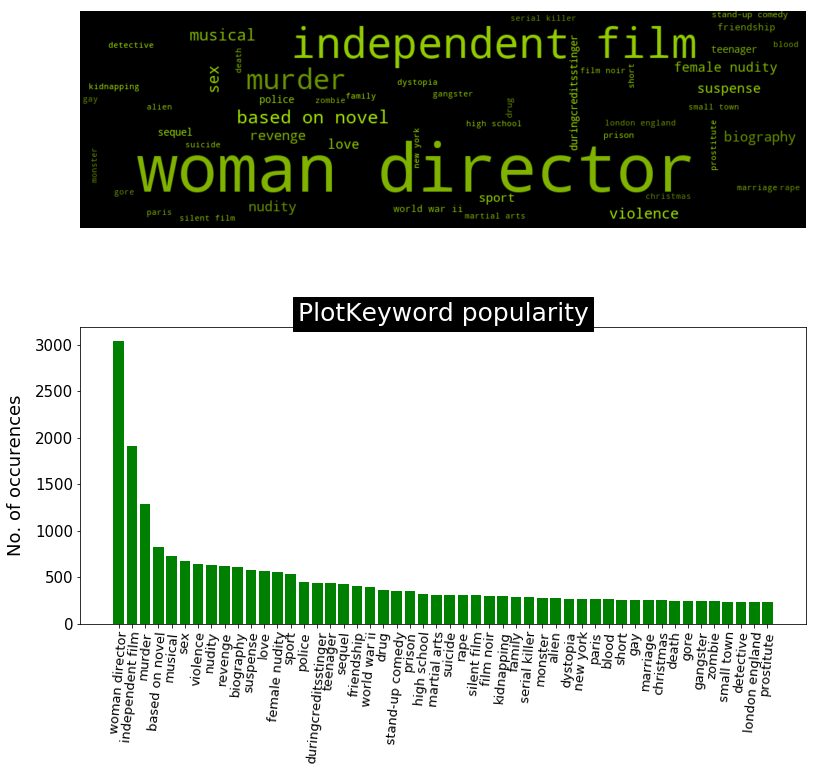




filling factor of each feature(column):
              column_name  missing_count  filling_factor
0   belongs_to_collection  40945          9.878282      
1   homepage               37659          17.110911     
2   tagline                25032          44.903484     
3   country                6282           86.173046     
4   actor_3_name           5777           87.284573     
5   actor_2_name           4645           89.776154     
6   language               3830           91.570004     
7   actor_1_name           3737           91.774701     
8   overview               954            97.900205     
9   director_name          887            98.047675     
10  poster_path            386            99.150397     
11  duration               260            99.427729     
12  title_year             87             99.808509     
13  release_date           87             99.808509     
14  status                 84             99.815112     
15  imdb_id                17             99.

In [7]:
print('\n\n\nThen show the wordcloud and histogram of the top 50 keywords...')
wordcloud_and_histogram(ko, show_histogram=True)
missing_df = missing_values(init_tmdb_movies)
print('\n\n\nfilling factor of each feature(column):')
print(missing_df)

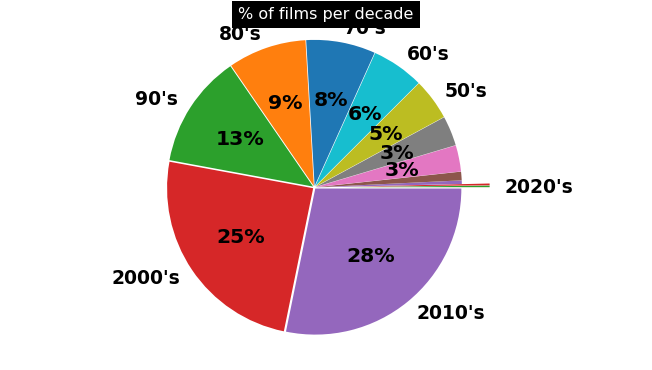




The top 10 genre by frequency:
['Drama', 20244]
['Comedy', 13176]
['Thriller', 7619]
['Romance', 6730]
['Action', 6592]
['Horror', 4671]
['Crime', 4304]
['Documentary', 3930]
['Adventure', 3490]
['Science Fiction', 3044]


In [8]:
group_by_decade_and_show(init_tmdb_movies)
liste = all_keywords(init_tmdb_movies, 'genres')
ko, kc = count_word(init_tmdb_movies, 'genres', liste)
print('\n\n\nThe top 10 genre by frequency:')
for k in ko[:10]: print(k)




Then show the wordcloud and histogram of the top 50 genres...


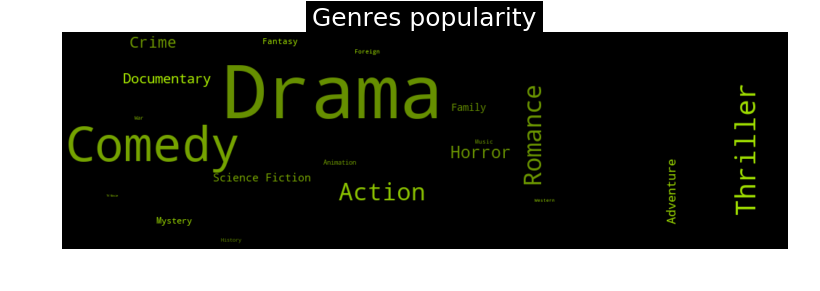

In [9]:
print('\n\n\nThen show the wordcloud and histogram of the top 50 genres...')
wordcloud_and_histogram(ko, False, 'Genres')

Num of entries that have the same movie title as some other entries: 5460
The details:
                        movie_title  title_year            director_name
42660  10 Minutes                    2014.0      Iván Dariel Ortiz      
24402  10 Minutes                    2002.0      Stefan Fjeldmark       
15194  12 Angry Men                  1997.0      Yosuke Fujita          
1161   12 Angry Men                  1957.0      Sidney Lumet           
32754  12 Chairs                     1976.0      Xavier Palud           
32768  12 Chairs                     1971.0      Charlie Levi           
12999  20,000 Leagues Under the Sea  1916.0      Jonathan Demme         
24092  20,000 Leagues Under the Sea  1997.0      Jeremiah Zagar         
20838  20,000 Leagues Under the Sea  1997.0      Kasper Barfoed         
990    20,000 Leagues Under the Sea  1954.0      Richard Fleischer      
20639  2:22                          2008.0      Jane Anderson          
44924  2:22                          

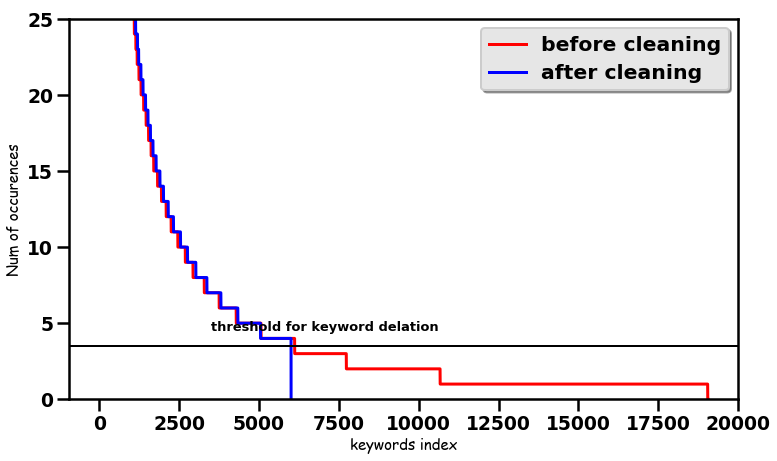

In [10]:
df_duplicate_cleaned = deduplicate(init_tmdb_movies)
_, _1, keywords_select = keywords_inventory(df_duplicate_cleaned)
df_keywords_cleaned = replacement_of_keywords(df_duplicate_cleaned, 
        keywords_select, column='plot_keywords', roots=True)
df_keyword_occurence = clean_keywords_with_low_freq(df_keywords_cleaned)
visualize_word_freq_diff(init_tmdb_movies, df_keyword_occurence)

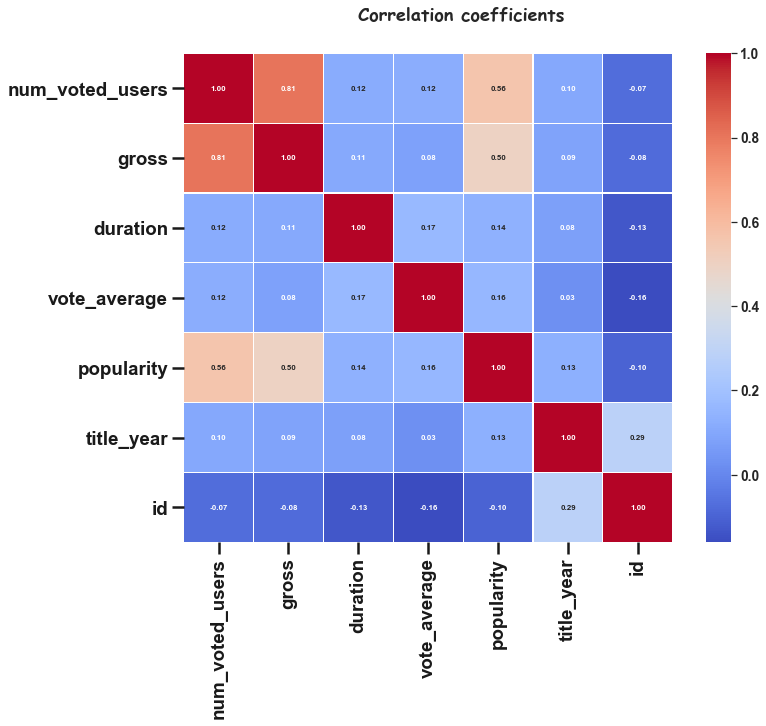




filling factor of each feature(column) again:
        column_name  missing_count  filling_factor
0   country          5884           86.082596     
1   actor_3_name     5324           87.407162     
2   actor_2_name     4285           89.864705     
3   language         3576           91.541700     
4   actor_1_name     3455           91.827901     
5   director_name    812            98.079379     
6   duration         251            99.406311     
7   title_year       82             99.806046     
8   movie_title      1              99.997635     
9   plot_keywords    1              99.997635     
10  num_voted_users  1              99.997635     
11  vote_average     1              99.997635     
12  gross            1              99.997635     
13  genres           0              100.000000    


In [11]:
correlation(df_keyword_occurence)
df_var_cleaned = drop_old_columns(df_keyword_occurence)
missing_df = missing_values(df_var_cleaned)
print('\n\n\nfilling factor of each feature(column) again:')
print(missing_df)

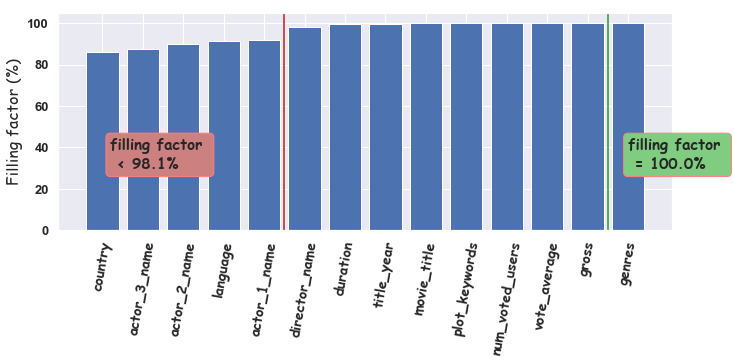

Find out records that miss title year.
                                   movie_title         director_name  \
711    War Stories Our Mother Never Told Us     NaN                    
734    Vermont Is for Lovers                    John O'Brien           
3459   Jails, Hospitals & Hip-Hop               Justin Kerrigan        
3627   Boricua's Bond                           Raúl Ruiz              
5878   Divine Intervention                      Fernando Meirelles     
13834  Bling: A Planet Rock                     Yann Arthus-Bertrand   
14796  Dead Ahead: The Exxon Valdez Disaster    Barry Primus           
16828  Das Experiment 770 - Gebären auf Befehl  John Whitesell         
16945  Connections                              Mikio Naruse           
17331  Human Failure                            NaN                    

               actor_1_name         actor_2_name      actor_3_name  
711    NaN                   NaN                  NaN               
734    Marya Cohn            A

In [12]:
visualize_filling_factor(df_var_cleaned)

print('Find out records that miss title year.')
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][
        ['movie_title', 'director_name', \
                'actor_1_name', 'actor_2_name', 'actor_3_name']]
print(missing_year_info[:10])

In [13]:
fill_year(df_filling)
extract_keywords_from_title(df_filling)
print('Pairplot of feature \'gross\' and \'num_voted_users\'.')

title:Vermont Is for Lovers                         -> year:2014                
title:Jails, Hospitals & Hip-Hop                    -> year:1992                
title:Boricua's Bond                                -> year:1992                
title:Divine Intervention                           -> year:2011                
title:Bling: A Planet Rock                          -> year:2004                
title:Dead Ahead: The Exxon Valdez Disaster         -> year:1991                
title:Das Experiment 770 - Gebären auf Befehl       -> year:1991                
title:Connections                                   -> year:1986                
title:Dreamkiller                                   -> year:1978                
Pairplot of feature 'gross' and 'num_voted_users'.


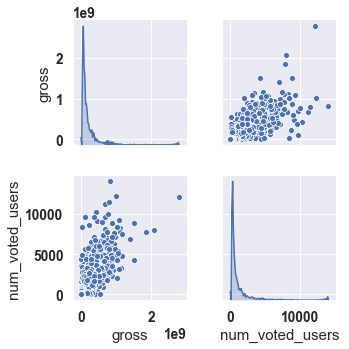




Finally, filling factor of each feature(column):
        column_name  missing_count  filling_factor
0   country          5884           86.082596     
1   actor_3_name     5324           87.407162     
2   actor_2_name     4285           89.864705     
3   language         3576           91.541700     
4   actor_1_name     3455           91.827901     
5   director_name    812            98.079379     
6   duration         251            99.406311     
7   title_year       12             99.971616     
8   movie_title      1              99.997635     
9   plot_keywords    1              99.997635     
10  num_voted_users  1              99.997635     
11  vote_average     1              99.997635     
12  gross            1              99.997635     
13  genres           0              100.000000    


/Users/lee/Documents/code/python/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [14]:
pairplot(df_filling, 'gross', 'num_voted_users')
variable_linreg_imputation(df_filling, 'gross', 'num_voted_users')
missing_df = missing_values(df_filling)
print('\n\n\nFinally, filling factor of each feature(column):')
print(missing_df)

In [15]:
print('dataset size before dropping: ', df_filling.shape[0])
df_filling = df_filling.replace([np.inf, -np.inf], np.nan)\
        .dropna(subset=df_filling.columns.values.tolist())
print('dataset size after dropping: ', df_filling.shape[0])
print('\n\n\n' + '='*40)
print('Below is the test cases:')

dataset size before dropping:  42278
dataset size after dropping:  30971



Below is the test cases:


In [17]:
for name in ['Avatar', 'Batman v Superman: Dawn of Justice', \
    'Pirates of the Caribbean: Dead Man\'s Chest', 'Men in Black 3']:
    iloc_name = df_filling[df_filling.movie_title == name].iloc[-1].name
    i = df_filling.index.get_loc(iloc_name)
    find_similarities(df_filling, i, del_sequels=True, verbose=True)

__________________________________________________________________________________________
QUERY: films similar to id=12301 -> '['Avatar']'
n1  -> Captain America: The Winter Soldier
n2  -> The Hunger Games: Catching Fire
n3  -> X-Men: Days of Future Past    
n4  -> Edge of Tomorrow              
n5  -> Thor: The Dark World          
n6  -> Rogue One: A Star Wars Story  
n7  -> The Fifth Element             
n8  -> The Nostalgist                
__________________________________________________________________________________________
QUERY: films similar to id=23104 -> '['Batman v Superman: Dawn of Justice']'
n1  -> Thor                          
n2  -> Iron Man 2                    
n3  -> Man of Steel                  
n4  -> The Amazing Spider-Man        
n5  -> The Wolverine                 
n6  -> Suicide Squad                 
n7  -> Warcraft                      
n8  -> Justice League: Crisis on Two Earths
________________________________________________________________________

## Group Presentation

blabla